In [7]:
import numpy as np
import pandas as pd
import sklearn
import catboost
import shap
import seaborn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import tensorflow as tf
import category_encoders

from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import OrdinalEncoder
from pandas_profiling import ProfileReport

from IPython.display import display, Markdown

# Problem Statement

Work with the attached dataset to identify users who are more likely to do a sale.

It's important for the business to understand **what makes someone more likely to buy** an insurance.
For this purpose, we assembled a dataset with features of users and their sessions and an indicator if they resulted in a sale or not.

Your goal is to work with this dataset and **identify users who are more likely to convert** so that we can personalise the experience for them.

We don't expect a perfect solution (actually, we believe there isn't one). But please take several hours to implement a well structured approach in a Jupyter notebook.

Afterwards, we'll discuss your solution in detail. Be ready to answer question like, why did you choose this approach and not others, how will you measure the performance of your solution and how do you interpret the final results


--------

# Data understanding

| field name   	| description                                                  	|
|--------------	|--------------------------------------------------------------	|
| id           	| unique identifier of the rows                                	|
| date         	| date of the session                                          	|
| campaign_id  	| id of the advertising campaign that led the user to the site 	|
| group_id     	| id of the group that lead the user to the site               	|
| age_group    	| age range of the user                                        	|
| gender       	| gender of the user                                           	|
| user_type    	| internal id of the type of user                              	|
| platform     	| device type of the user                                      	|
| state_id     	| US state id of the user location                             	|
| interactions 	| number of interactions of the user                           	|
| sale         	| boolean indicator if the user has made a sale or not         	|

## Read-in the data

In [982]:
sales_data = pd.read_csv('sales_data.csv.gz',
                          compression='gzip',
                          sep=',',
                          header=0,
                          index_col=0)

In [983]:
sales_data

,date,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions,sale
id,,,,,,,,,,
277133,2021-05-04,3,372,45-49,F,0,desktop,19,5249,0.0
270342,2021-05-04,3,313,35-39,F,4,desktop,16,1522,0.0
161280,2021-05-02,3,321,30-34,M,1,desktop,25,2,0.0
252773,2021-05-04,3,426,30-34,F,0,NaN,27,2,1.0
118886,2021-05-01,3,337,40-44,M,8,desktop,16,2,0.0
...,...,...,...,...,...,...,...,...,...,...
71168,2021-05-01,3,404,30-34,F,2,NaN,5,2,0.0
8348,2021-05-01,3,329,35-39,F,2,desktop,26,1625,0.0
242565,2021-05-04,3,361,35-39,F,7,desktop,12,2,0.0


**Let's use `pandas_profiling` for a quick and exhaustive summary of all features and their interactions**

In [984]:
profile = ProfileReport(sales_data, title="Sales Data Report", explorative=True,
                        dark_mode=True)

In [985]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

overflow encountered in long_scalars


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# profile.to_notebook_iframe()

**Below are some observations extracted from `pandas_profiling`**:

  1. There are 28 missing values in the target `sale`. We will safely remove
     those from the dataset, prior to any further analysis
     
   
     
  2. Huge imbalance in the target `sale` - 93.6% of all observations have **not**
     resulted in a sale. 
     This imbalance must be addressed before model training and will determine
     the performance metric we chose.
     
  
  3. There is considerable imbalance in the feature `platform` - approximately 63% of users 
     come from a desktop machine, 36% have missing values and less than 1% come from
     mobile devices.
     Depending on whether the missing values represent merely a data quality
     issue or an actual meaningful signal about user behaviour (e.e. user redirected
     through third parties have "undetected" platform), we can either impute
     the missing values or model them as a separate entity.
     In this submission I have chosen the latter.
   
   
  4. All features, except `interactions` are categorical.
     We will have to encode them to be able to use most machine learning methods.
     In this submission I have tried two methods - one-hot encoding and leave-one-out target coding.
     They both perform similarly, so I leave the latter in the main code.
   
  
  5. The feature `interactions` is heavily skewed. 
     We will log-transform it to make it more Gaussian-like and hence reduce the likelihood
     that its heavy tails bias our models.
     
     
  6. The features `group_id` and `user_type` have high cardinalities. If categorical features are one-hot encoded
     this will be a problem, as this will induce a lot of spareness in the encoded dataset.
     Furthermore, features with many categories will bias most learning algorithms in their favour.
     The one-hot encoding in the submission reduces the cardinality of this feature by contracting it with
     a new category "Other".
     
     
  7. The *Phi_K* correlation plot suggests correlation between `sales` and the features `age_group`,
     `gender` and `state_id`. 
     Despite being only visual this observation is a first indication of what features might be
     influential in this problem and should be verified.
     
     
  8. The `date`feature has only 9 distinct values and doesn't provide enough information for
     time series analysis. We will thus drop it.

## Clean-up

**Let's remove the observation with missing target `sale`**

In [987]:
empty_sales_mask = np.isnan(sales_data['sale'])

sales_data_cleaned = sales_data[~empty_sales_mask].copy()

In [988]:
sales_data_cleaned

,date,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions,sale
id,,,,,,,,,,
277133,2021-05-04,3,372,45-49,F,0,desktop,19,5249,0.0
270342,2021-05-04,3,313,35-39,F,4,desktop,16,1522,0.0
161280,2021-05-02,3,321,30-34,M,1,desktop,25,2,0.0
252773,2021-05-04,3,426,30-34,F,0,NaN,27,2,1.0
118886,2021-05-01,3,337,40-44,M,8,desktop,16,2,0.0
...,...,...,...,...,...,...,...,...,...,...
71168,2021-05-01,3,404,30-34,F,2,NaN,5,2,0.0
8348,2021-05-01,3,329,35-39,F,2,desktop,26,1625,0.0
242565,2021-05-04,3,361,35-39,F,7,desktop,12,2,0.0


**As mentioned before we will keep the mising values as a special category
to be explicitly modelled**.

This affects mostly the `platform` feature, since it has the highest
fraction of missing values.

In [989]:
sales_data_cleaned = sales_data_cleaned.fillna('not available')

And finally removing `date`

In [990]:
sales_data_cleaned = sales_data_cleaned.drop(columns='date')

## Train-test split

Before we continue we'll allocate a *test* set to be used as a proxy for *unseen* data. 
That would be the final dataset on which models will be compared at the end.

Importantly this must be done before any encoding or rebalancing.
We want to keep the data imbalance in the test set and check model performance on it.
In this way we'll know if our model has learned useful information to detect
the positive signal resulting in a sale.

Any rebalancing or encoding will be learned from the training dataset to ensure 
no data leakage.

To generate the split and keep the data imbalance, we use `StratifiedShuffleSplit`
and take 20% of the data as test.



In [991]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

all_but_target = sales_data_cleaned.columns != 'sale'
X = sales_data_cleaned.loc[:, all_but_target]
y = sales_data_cleaned[['sale']]


for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

In [500]:
y.groupby(by='sale').size()

sale
0.0    398800
1.0     27496
dtype: int64

In [501]:
y_train.groupby(by='sale').size()

sale
0.0    319039
1.0     21997
dtype: int64

In [502]:
y_test.groupby(by='sale').size()

sale
0.0    79761
1.0     5499
dtype: int64

As we can see the imbalance in `sale` is very similar across the original
dataset, the training dataset and the test dataset.

# Data Processing Pipelines

As a last step before modelling, we'll create the encoding and 
rebalancing logic.

There are many options to encode categorical variables with the 
most popular one being **one-hot encoding**.
Its alternative name, *dummy coding*, suggests that it may not be
the obvious choice for all problems.
Nevertheless I have supplied an implementation for it.

Another category of encoding methods is known as **target coding**, 
where the main idea is that information about the target (e.g. mean value)
conditional on the individual categories is used to encode them.
The encoding is typically futher combined with the so-called *prior*, which
represents a global statistic unconditioned on any category.

There are several target-coding methods implemented in the Python package
`category_encoders`.

I have tried `TargetEncoder` and `LeaveOneOutEncoder`, both with similar performance.


In [992]:
X_train

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
id,,,,,,,,
148921,3,380,35-39,F,5,desktop,22,230
421695,3,438,35-39,F,1,not available,12,2
404077,3,402,35-39,M,2,not available,28,820
49202,3,349,40-44,M,7,desktop,50,139
348599,3,433,45-49,F,5,not available,15,1706
...,...,...,...,...,...,...,...,...
410359,3,426,45-49,F,2,not available,10,2
403996,3,228,35-39,M,1,desktop,2,2
74562,3,395,30-34,M,8,desktop,7,1173


In [993]:
# We need to keep these around for convenience later on
feature_cols = ['campaign_id', 'group_id', 'age_group', 'gender', 'user_type', 'platform', 'state_id', 'interactions']
cat_cols = ['campaign_id', 'group_id', 'age_group', 'gender', 'user_type', 'platform', 'state_id']
target_col = ['sale']

Before, we continue let's define a function to log-transform the `interactions`
feature.
It will be used in the final `sklearn.pipeline.Pipeline`

## Log-transform `interactions`

In [1004]:
def log_trans(df):
    df['interactions'] = np.log10(df['interactions'])
    return pd.DataFrame(df, columns=df.columns)


## Categorical Encoding

### Target coding

In [1005]:
# both do very similary

leave_one_out_enc = \
    category_encoders.leave_one_out.LeaveOneOutEncoder(cols=cat_cols,
                                                       random_state=42,
                                                       sigma=0.05)

target_encoder = \
    category_encoders.target_encoder.TargetEncoder(cols=cat_cols,                                                                
                                                   min_samples_leaf=500,
                                                   smoothing=1)

### One hot encoding

In [1006]:
for col in cat_cols:
    # all, but the last one 'interactions'
    X_train[col] = X_train[col].astype('str')
    X_test[col] = X_test[col].astype('str')

In [1007]:
campaign_id_cats = list(X_train['campaign_id'].value_counts().index)
group_id_cats = list(X_train['group_id'].value_counts().index)
age_group_cats = list(X_train['age_group'].value_counts().index)
gender_cats = list(X_train['gender'].value_counts().index)
user_type_cats = list(X_train['user_type'].value_counts().index)
platform_cats = list(X_train['platform'].value_counts().index)
state_id_cats = list(X_train['state_id'].value_counts().index)

In [1024]:
def reduce_column(df, column, q):  
    
    column_freqs = pd.DataFrame(df[column].value_counts())
    column_freqs = column_freqs.reset_index().rename(columns={'index': column,
                                                               column: 'count'})
    
    
    quantile = np.int(np.floor(np.quantile(column_freqs['count'], q=q/100)))
    threshold_mask = column_freqs['count'] > quantile
    
    
    df[column] = np.where(df[column].isin(column_freqs[~threshold_mask][column]), 'Other', df[column])
    
    return pd.DataFrame(df, columns=df.columns)

In [1027]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories=[campaign_id_cats,
                                group_id_cats,
                                age_group_cats,
                                gender_cats,
                                user_type_cats,
                                platform_cats,
                                state_id_cats],
                    drop='first', sparse=False)

encoder = ColumnTransformer([('cat', enc, cat_cols)],
                              remainder='passthrough')



ohe_pipe = Pipeline([("reduce_group_id",
                      FunctionTransformer(reduce_column,
                                         kw_args={'q': 99,
                                        'column': 'group_id'})),
         
                     ("one_hot_encoding", encoder)])

**And finally define the encoding pipeline**

In [1038]:
# both target-coding methods do very similary in terms of mode performance
# to use one hot encoding, instead, we must contract the `group_id` feature, 
# otherwise there'll be too much sparseness and bias towards that feature

encoding_pipeline = Pipeline([
    ("log_trans_interactions", FunctionTransformer(log_trans)),
    # ("target_encoder", target_encoder),
    ('leave_one_out_enc', leave_one_out_enc),    
    # ("one_hot_encoding", encoder)
    ] + ohe_pipe.steps)


We now learn the encoding from our training dataset and use it to
transform the test dataset.

In [1010]:
X_train_processed = encoding_pipeline.fit_transform(X_train.copy(), y_train)

# importantly, only transform X_test, don't fit it
X_test_processed = encoding_pipeline.transform(X_test.copy())

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


**This is how our encoded training dataset looks like:**

In [1011]:
X_train_processed

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
id,,,,,,,,
148921,0.064972,0.058964,0.058979,0.076748,0.058101,0.064608,0.066816,2.361728
421695,0.062959,0.057963,0.053258,0.084822,0.061982,0.065355,0.059073,0.301030
404077,0.065451,0.063377,0.055670,0.044467,0.070165,0.063153,0.077831,2.913814
49202,0.068225,0.060133,0.081790,0.052788,0.065206,0.063335,0.055190,2.143015
348599,0.062655,0.071872,0.089473,0.078551,0.068743,0.066866,0.032520,3.231979
...,...,...,...,...,...,...,...,...
410359,0.060622,0.067146,0.091456,0.077340,0.061130,0.064453,0.056765,0.301030
403996,0.065305,0.053810,0.053451,0.048431,0.061702,0.064885,0.060694,0.301030
74562,0.060387,0.060852,0.040525,0.052182,0.066841,0.067272,0.047185,3.069298


**This is how our encoded test dataset looks like:**

In [1012]:
X_test_processed

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
id,,,,,,,,
137980,0.063397,0.075871,0.050993,0.076757,0.066394,0.062852,0.052820,3.821251
268057,0.063397,0.071778,0.050993,0.076757,0.065721,0.065366,0.055466,0.301030
97548,0.063397,0.069227,0.088960,0.076757,0.062918,0.062852,0.058394,3.533136
412151,0.063397,0.074661,0.040761,0.050327,0.062448,0.065366,0.035693,4.291458
164008,0.063397,0.064941,0.080211,0.050327,0.062448,0.065366,0.052979,3.745465
...,...,...,...,...,...,...,...,...
137183,0.063397,0.060465,0.050993,0.050327,0.064885,0.062852,0.049427,0.301030
291801,0.093611,0.117647,0.040761,0.076757,0.064885,0.069317,0.052979,0.301030
303190,0.063397,0.062682,0.050993,0.050327,0.065721,0.062852,0.058394,3.034227


## Re-balancing `sale`

Rebalancig the `sale` feature is very important during training, if
we don't want our models to simply learn to predict the majority class.

While choosing a scoring metric appropriate for imbalanced datasets is
certainly important, that alone is often not enough.

For this reason, in addition to choosing an appropriate metric, we will rebalance 
the target

Because there're plenty of samples, I have opted for a downsampling strategy of
the majority class (no sale).
By reducing the size of the dataset all further analysis downstream
(including modelling) will be sped up, which in the context of this submission
was an important factor.

There are many ways to down- or under-sample a majority class. 
By far a popular first choice is the random under-sampler, which, as the name
suggests, randomply selects majority samples until a desired proportion
of majority and minority samples is achieved.

The random under-sampler is extremely fast and suitable for mixed data.
Caution must be taken to sample sufficiently from the distribution of the
majority class, so that its properties are preserved in the undersampled dataset.

I have also tried other popular methods from `imblearn`, which had similar
results and the cost of processing time.

For this reason, the random under-sampler is provided in the main code.

In [1013]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

### Random undersampler

In [1051]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=1, replacement=False)
tomek = TomekLinks(sampling_strategy='all', n_jobs=-1)
nearmiss = NearMiss(sampling_strategy=1, version=1, n_jobs=-1, n_neighbors=3)

X_train_processed_resampled, y_train_processed_resampled = rus.fit_resample(X=X_train_processed, y=y_train)
sample_indeces = rus.sample_indices_

# X_train_processed_resampled, y_train_processed_resampled = tomek.fit_resample(X=X_train_processed, y=y_train)
# sample_indeces = tomek.sample_indices_

# X_train_processed_resampled, y_train_processed_resampled = nearmiss.fit_resample(X=X_train_processed, y=y_train)
# sample_indeces = nearmiss.sample_indices_


And this is the rebalanced training data

In [1052]:
X_train_processed_resampled

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
0,0.063131,0.067561,0.089640,0.051975,0.066639,0.070138,0.055140,3.147058
1,0.062972,0.064806,0.081564,0.050470,0.064988,0.065714,0.053772,0.301030
2,0.060136,0.057024,0.037093,0.046639,0.072868,0.067875,0.056041,0.301030
3,0.060811,0.070793,0.049056,0.081000,0.071178,0.067022,0.058759,3.332438
4,0.063654,0.061823,0.079296,0.075416,0.069616,0.060174,0.057421,0.301030
...,...,...,...,...,...,...,...,...
43989,0.060076,0.057429,0.041666,0.076181,0.066933,0.064027,0.070167,0.301030
43990,0.063514,0.081057,0.096937,0.073002,0.066066,0.066857,0.138660,3.925157
43991,0.069869,0.067323,0.093553,0.075415,0.064779,0.062597,0.052129,3.189771
43992,0.060202,0.061539,0.050127,0.054611,0.061012,0.058063,0.135085,3.628593


corresponding to the original:

In [1054]:
X_train.iloc[sample_indeces]

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
id,,,,,,,,
167697,3,347,45-49,M,0,desktop,10,1403
91754,3,414,45-49,M,2,not available,10,2
157719,3,352,30-34,M,8,desktop,10,2
63640,3,290,35-39,F,4,desktop,10,2150
104954,3,466,45-49,F,2,not available,10,2
...,...,...,...,...,...,...,...,...
308051,3,404,30-34,F,3,not available,28,2
286593,3,311,45-49,F,0,desktop,27,8417
367150,3,403,45-49,F,8,not available,16,1548


In [1023]:
t = y_train_processed_resampled.groupby(by='sale').size()
t2 = y_train.groupby(by='sale').size()
t3 = y_test.groupby(by='sale').size()

ratio_positives = t[1] / (t[0] + t[1])
ratio_positives_orig = t2[1] / (t2[0] + t2[1])
ratio_positives_test = t3[1] / (t3[0] + t3[1])

display(Markdown(f"**Ratio of positive targets in original training data is: {ratio_positives_orig}**"))
display(Markdown(f"**Ratio of positive targets in test data is: {ratio_positives_test}**"))
display(Markdown(f"**Ratio of positive targets in rebalanced training data is: {ratio_positives}**"))

**Ratio of positive targets in original training data is: 0.06450052193903283**

**Ratio of positive targets in test data is: 0.06449683321604503**

**Ratio of positive targets in rebalanced training data is: 0.5**

As we see the rebalanced training data has an equal proportion of
minority and majority samples

In [906]:
def reduce_column(df, column, q):  
    
    column_freqs = pd.DataFrame(df[column].value_counts())
    column_freqs = column_freqs.reset_index().rename(columns={'index': column,
                                                               column: 'count'})
    
    
    quantile = np.int(np.floor(np.quantile(column_freqs['count'], q=q/100)))
    threshold_mask = column_freqs['count'] > quantile
    
    
    df[column] = np.where(df[column].isin(column_freqs[~threshold_mask][column]), 'Other', df[column])
    
    return pd.DataFrame(df, columns=df.columns)

# the last two steps are optional, comment out if needed
data_preparation_pipeline = Pipeline([
    ("log_trans_interactions", FunctionTransformer(log_trans)),
    ("reduce_group_id", FunctionTransformer(reduce_column, kw_args={'q': 99, 'column': 'group_id'})),
    ("reduce_user_type", FunctionTransformer(reduce_column, kw_args={'q': 80, 'column': 'user_type'}))            
])

In [907]:
# the last two steps are optional, comment out if needed
data_preparation_pipeline = Pipeline([
    ("log_trans_interactions", FunctionTransformer(log_trans)),
    ("reduce_group_id", FunctionTransformer(reduce_column, kw_args={'q': 99, 'column': 'group_id'})),
    ("reduce_user_type", FunctionTransformer(reduce_column, kw_args={'q': 80, 'column': 'user_type'}))            
])


------

# Modelling

Before we begin modelling, we need to define the performance metric to optimize.

The *f1 score* and *balanced accuracy* are suitable metrics for imbalanced datasets.
Even though we rebalanced our training data, we still want to be sensitive
to trivial predictions on the (imbalanced) test data.

For this reason the *f1 score* will be used as a performance metric with
the added convenience that to compute it we will require the *precision*
and *recall* of our classifiers. 

These are important indicators, specifically when a tradeoff between false positives
and true negatives is an integral part of the business question, as it is here.


Essentially low precision, but high recall, will allows us to identify interested
customers well, at the expense of maybe bothering uninterested customers.

And vice versa, high precision and low recall will ensure that we only spend effort in
contacting "sure" sales, at the expense of possibly omitting others with buying inclinations.

----

As a first point, let's calculate the expected f1 score of a dummy classifier that
always predicts the minority class on the test set (i.e. recall is 1).
Such a classifier does not learn from the training data at all.

This will serve as our lowest possible benchmark.
If a model performs worse than that, we will know there've been serious
issues during training.


In [1046]:
dummy_clf_f1 = 2*ratio_positives_test / (ratio_positives_test + 1)

display(Markdown("**Expected F1 Score of a dummy classifier predicting "
                 f"always positive is: {dummy_clf_f1}**"))

**Expected F1 Score of a dummy classifier predicting always positive is: 0.12117806498529071**

## Baseline Models

In addition to

### Statsmodels Logistics Regression

In [1195]:
sm_train_data = X_train.iloc[sample_indeces].join(y_train.iloc[sample_indeces])
sm_test_data = X_test.join(y_test)


"""
Uncomment below if target-coding is desired (**)
""";

# sm_train_data = X_train_processed_resampled.join(y_train_processed_resampled)
# sm_test_data = X_test_processed.join(y_test)



In [1168]:
# we drop the high cardinality group_id and user_type features

formula = ('sale ~ C(campaign_id, Treatment(reference="3")) + '
           #'C(group_id) + '
           'C(age_group, Treatment(reference="30-34")) + '
           'C(gender, Treatment(reference="F")) + '
           # 'C(user_type) +'
           'C(platform) + '
           'C(state_id) + '
           'interactions')


"""
Uncomment below if target-coding is desired (**)
""";

# formula = ('sale ~ campaign_id + '
#            'group_id + '
#            'age_group + '
#            'gender + '
#            'user_type +'
#            'platform  + '
#            'state_id + '
#            'interactions')



log_reg_sm = smf.logit(formula=formula, data=sm_train_data).fit()

Optimization terminated successfully.
         Current function value: 0.653719
         Iterations 5


In [1169]:
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg_sm.params,
        "Lower CI": log_reg_sm.conf_int()[0],
        "Upper CI": log_reg_sm.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios["p-values"] = log_reg_sm.pvalues

In [1134]:
# log_reg_sm.summary()

Let's see only the odds ratios corresponding to categories with considerable
statistical significance


In [1170]:
odds_ratios[odds_ratios['p-values'] < 0.01]

,OR,Lower CI,Upper CI,p-values
Intercept,0.462120,0.343505,0.621693,3.385482e-07
"C(campaign_id, Treatment(reference=""3""))[T.2]",1.493511,1.347583,1.655242,2.063944e-14
"C(age_group, Treatment(reference=""30-34""))[T.35-39]",1.315446,1.237273,1.398559,1.768920e-18
"C(age_group, Treatment(reference=""30-34""))[T.40-44]",2.372429,2.232821,2.520767,1.574143e-171
"C(age_group, Treatment(reference=""30-34""))[T.45-49]",2.518744,2.389119,2.655401,2.400744e-257
"C(gender, Treatment(reference=""F""))[T.M]",0.698323,0.669114,0.728808,5.940879e-61
C(state_id)[T.14],2.328141,1.623605,3.338399,4.317670e-06
C(state_id)[T.19],2.041204,1.492378,2.791862,7.981433e-06
C(state_id)[T.20],1.925581,1.408468,2.632548,4.016000e-05
C(state_id)[T.22],1.932965,1.396582,2.675357,7.061622e-05


**Already here we see some interesting insights**:


  1. Four features appear to be most prominent - `campain_id`, `age_group`, `gender` and `state_id`.
     Incidently, three of those we have already hypothesized to be correlated with the
     target in our visual inspection with `pandas_profiling`
     

  2. The odds ratios increase monotonously with age. The probability of sale is 2.52 times higher
     among customers in the 45-49 age group, compared to the treatment 30-34 age
     group. Likewise for the other age groups. 
     This is reasonable, as it could be argued that younger people are less interested
     in buying insurance than older ones
     
     
  3. Males have 0.7 times **less** probability than females of buying insurace.
     That is interesting, but without knowing more context, it's hard to reality check it. 
     However, it may be related to aggresiveness and risk aversion
     
     
  4. Certain state_ids, namely 24, 25 and 27 almost triple the probability of a sale.
     That's quite interesting and deservers further investigations with more context

### Logistics Regression

In [1136]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(penalty='l2',
                                 random_state=42,
                                 class_weight='balanced',
                                 max_iter=300, n_jobs=-1)

lr_pipe = Pipeline([("lr_classifier", clf_log_reg)])



parameters = {'lr_classifier__C': [0.05, 0.1, 0.5, 1],
              'lr_classifier__tol': [0.0001, 0.001]}

clf_grid_search = GridSearchCV(lr_pipe,
                               param_grid=parameters,
                               scoring='f1',
                               refit=True,
                               cv=5,
                               n_jobs=-1,
                               verbose=0)

In [1137]:
clf_grid_search.fit(X_train_processed_resampled,
                    y_train_processed_resampled['sale']);

In [1140]:
best_estimator_lr = clf_grid_search.best_estimator_

### Random Forest Classifier

In [1141]:
from sklearn.ensemble import RandomForestClassifier

In [1188]:
clf_rf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
rf_pipe = Pipeline([("rf_classifier", clf_rf)])

In [1189]:
rf_pipe.fit(X_train_processed_resampled, y_train_processed_resampled['sale']);

### Comparison

In [1146]:
pos_label_index_lr = np.where(best_estimator_lr['lr_classifier'].classes_ == 1)[0]
pos_label_index_rf = np.where(rf_pipe['rf_classifier'].classes_ == 1)[0]

In [1171]:
y_pred_lr = best_estimator_lr.predict_proba(X_test_processed)[:,pos_label_index_lr]
y_pred_rf = rf_pipe.predict_proba(X_test_processed)[:,pos_label_index_rf]
y_pred_sm = log_reg_sm.predict(sm_test_data)

**Feature Importance**

In [1190]:
def plot_feature_importance(estimator, X, y, label='Permutation Importances (test set)'):

    result = permutation_importance(estimator, X, y,
                                    scoring='f1',
                                    n_repeats=10, random_state=42, n_jobs=-1)
    result['importances_mean']
    
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx]
    )
    ax.set_title(label)
    fig.tight_layout()
    plt.show()

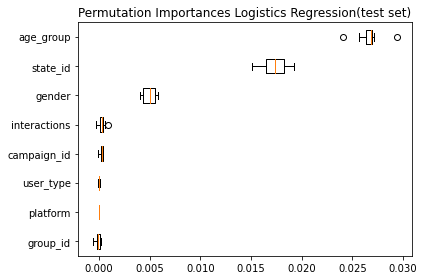

In [1191]:
plot_feature_importance(best_estimator_lr, X_test_processed, y_test,
                        label='Permutation Importances Logistics Regression(test set)')

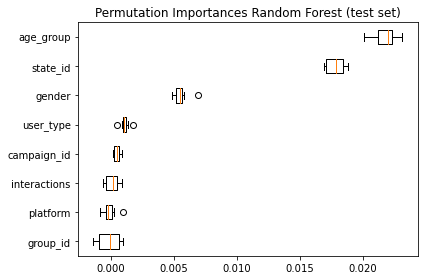

In [1192]:
plot_feature_importance(rf_pipe, X_test_processed, y_test,
                        label='Permutation Importances Random Forest (test set)')

**F1 Score**

In [1173]:
score_lr = f1_score(y_test['sale'], best_estimator_lr.predict(X_test_processed))
score_rf = f1_score(y_test['sale'], rf_pipe.predict(X_test_processed))
score_sm = f1_score(y_test['sale'], 1 * (y_pred_sm > 0.5))

In [1174]:
score_lr

0.16370220959017145

In [1175]:
score_rf

0.1584774797359405

In [1176]:
score_sm

0.17048010169160063

In [1177]:
f1scores_lr = []
f1scores_rf = []
f1scores_sm = []

max_f1 = -10
max_th = -10

for th in np.linspace(0, 1, 9):
    f1_lr = f1_score(y_test['sale'], 1 * (y_pred_lr > th))
    f1_rf = f1_score(y_test['sale'], 1 * (y_pred_rf > th))
    f1_sm = f1_score(y_test['sale'], 1 * (y_pred_sm > th))
    
    if f1_lr > max_f1:
        max_f1 = f1_lr
        max_th = th
        
    if f1_rf > max_f1:
        max_f1 = f1_rf
        max_th = th
        
    if f1_sm > max_f1:
        max_f1 = f1_sm
        max_th = th
        
    f1scores_sm.append(f1_sm)
    f1scores_lr.append(f1_lr)
    f1scores_rf.append(f1_rf)

In [1178]:
max_f1

0.17048010169160063

In [1179]:
max_th

0.5

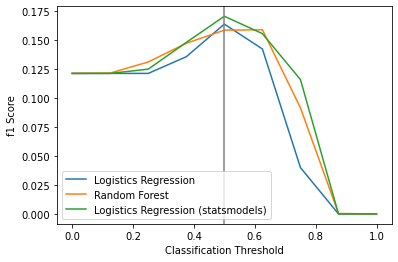

In [1180]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_lr, estimator=None, ax=axes, label='Logistics Regression');
seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_rf, estimator=None, ax=axes, label='Random Forest');
seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_sm, estimator=None, ax=axes,
                 label='Logistics Regression (statsmodels)');
plt.axvline(x=max_th, color='grey')


plt.xlabel('Classification Threshold');
plt.ylabel('f1 Score');


**ROC Curve**

In [1181]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)

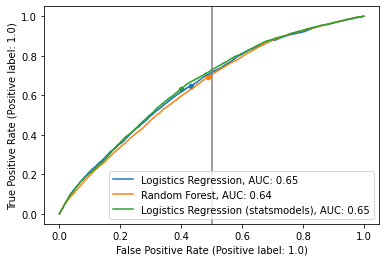

In [1182]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes, label=f'Logistics Regression, AUC: {auc_lr}');
seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes, label=f'Random Forest, AUC: {auc_rf}');
seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');

idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[fpr_lr[idx_lr]], y=[tpr_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[fpr_rf[idx_rf]], y=[tpr_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[fpr_sm[idx_sm]], y=[tpr_sm[idx_sm]], ax=axes)

plt.axvline(x=0.5, color='grey')

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


**PR Curve**

In [1183]:
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test, y_pred_lr)
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
precisions_sm, recalls_sm, thresholds_sm = precision_recall_curve(y_test, y_pred_sm)

<AxesSubplot:ylabel='Count'>

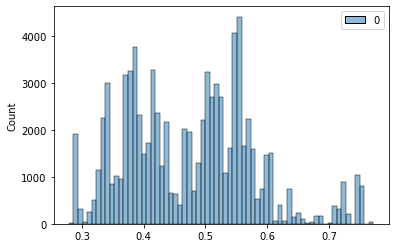

In [1184]:
seaborn.histplot(y_pred_lr)

<AxesSubplot:ylabel='Count'>

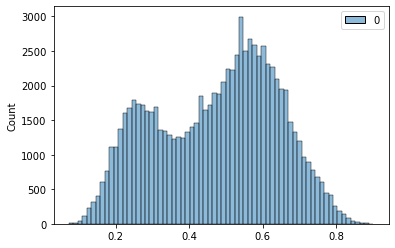

In [1185]:
seaborn.histplot(y_pred_rf)

<AxesSubplot:ylabel='Count'>

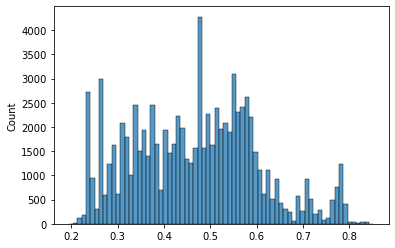

In [1186]:
seaborn.histplot(y_pred_sm)

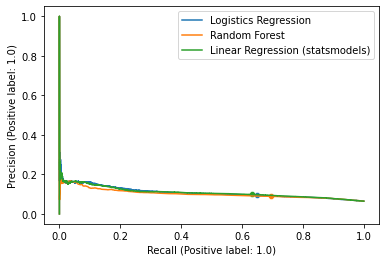

In [1187]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=recalls_lr, y=precisions_lr,
                 estimator=None, ax=axes, label=f'Logistics Regression');
seaborn.lineplot(x=recalls_rf, y=precisions_rf,
                 estimator=None, ax=axes, label=f'Random Forest');
seaborn.lineplot(x=recalls_sm, y=precisions_sm,
                 estimator=None, ax=axes, label=f'Linear Regression (statsmodels)');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[recalls_lr[idx_lr]], y=[precisions_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[recalls_rf[idx_rf]], y=[precisions_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[recalls_sm[idx_sm]], y=[precisions_sm[idx_sm]], ax=axes)

plt.xlabel('Recall (Positive label: 1.0)');
plt.ylabel('Precision (Positive label: 1.0)');


## Challenger Model

### Gradient Boosting

In [1196]:
from catboost import CatBoostClassifier, Pool, cv

cat_features = [0, 1, 2, 3, 4, 5, 6]

# train_dataset = Pool(data=X_train_processed_resampled,
#                     label=y_train_processed_resampled['sale'])#, cat_features=cat_features)
# test_dataset = Pool(data=X_test_processed, label=y_test['sale'])#, cat_features=cat_features)

X_train.iloc[sample_indeces].join(y_train.iloc[sample_indeces])


train_dataset = Pool(data=X_train.iloc[sample_indeces],
                     label=y_train.iloc[sample_indeces]['sale'],
                     cat_features=cat_features)
test_dataset = Pool(data=X_test, label=y_test['sale'],
                    cat_features=cat_features)

In [1197]:
clf = CatBoostClassifier(depth=5,
                         iterations=1000,
                         l2_leaf_reg=1,
                         loss_function="Logloss",
                         eval_metric="F1",
                         logging_level='Silent',
                         boost_from_average=True,
                         langevin=True)

In [1198]:
clf.fit(train_dataset)

In [1199]:
pos_label_index_cb = np.where(clf.classes_ == 1)[0]

y_pred_cb = clf.predict_proba(test_dataset)[:,pos_label_index_cb]

<AxesSubplot:ylabel='Count'>

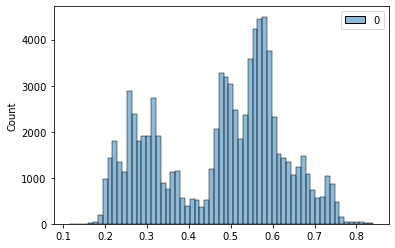

In [1205]:
seaborn.histplot(y_pred_cb)

In [1200]:
score_cb = f1_score(test_dataset.get_label(),
                    clf.predict(test_dataset))

In [1206]:
score_cb

0.16316135065761983

In [1202]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_cb)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)
auc_cb = np.round(roc_auc_score(y_test, y_pred_cb), 2)

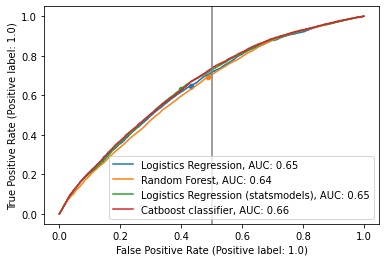

In [1203]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes, label=f'Logistics Regression, AUC: {auc_lr}');
seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes, label=f'Random Forest, AUC: {auc_rf}');
seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');
seaborn.lineplot(x=fpr_cb, y=tpr_cb, estimator=None, ax=axes,
                 label=f'Catboost classifier, AUC: {auc_cb}');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[fpr_lr[idx_lr]], y=[tpr_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[fpr_rf[idx_rf]], y=[tpr_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[fpr_sm[idx_sm]], y=[tpr_sm[idx_sm]], ax=axes)

plt.axvline(x=0.5, color='grey')

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


In [1204]:
clf.get_feature_importance(data=test_dataset, type='PredictionValuesChange', prettified=True)

,Feature Id,Importances
0,state_id,33.188040
1,age_group,27.820842
2,gender,11.525431
3,group_id,9.650438
4,user_type,6.272892
5,campaign_id,4.912181
6,interactions,4.517615
7,platform,2.112560


### Neural Network

In [950]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

@tf.autograph.experimental.do_not_convert
def f1_nn(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model():

    nn = tf.keras.Sequential([    
        tf.keras.layers.Dense(128, input_dim=X_train_processed_resampled.shape[1], activation='relu'),
        tf.keras.layers.Dense(32, input_dim=128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_nn])
    
    return nn


In [951]:

clf_nn = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, use_multiprocessing=True)

In [952]:
clf_nn.fit(X_train_processed_resampled, y_train_processed_resampled['sale'])

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.6844 - f1_nn: 0.4783
Epoch 2/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6629 - f1_nn: 0.5920
Epoch 3/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6598 - f1_nn: 0.6132
Epoch 4/20
1375/1375 [==============================] - 1s 999us/step - loss: 0.6592 - f1_nn: 0.6207
Epoch 5/20
1375/1375 [==============================] - 1s 968us/step - loss: 0.6578 - f1_nn: 0.6274
Epoch 6/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.6581 - f1_nn: 0.6310
Epoch 7/20
1375/1375 [==============================] - 1s 960us/step - loss: 0.6579 - f1_nn: 0.6271
Epoch 8/20
1375/1375 [==============================] - 1s 999us/step - loss: 0.6568 - f1_nn: 0.6316
Epoch 9/20
1375/1375 [==============================] - 1s 958us/step - loss: 0.6580 - f1_nn: 0.6293
Epoch 10/20
1375/1375 [==============================] - 1s 958us/step - loss: 0.6571 - f1_nn: 0.63

In [953]:
y_pred_nn = clf_nn.predict(X_test_processed)

<AxesSubplot:ylabel='Count'>

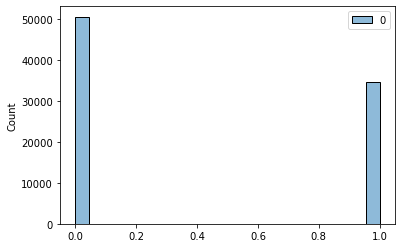

In [954]:
seaborn.histplot(y_pred_nn)

In [955]:
f1_score(y_test['sale'], y_pred_nn)

0.16776602364654636

In [956]:
y_pred_nn_raw = clf_nn.predict_proba(X_test_processed)

In [957]:
y_pred_nn_raw[:, 1]

array([0.3279399 , 0.34944278, 0.5372196 , ..., 0.31070524, 0.5788075 ,
       0.58738047], dtype=float32)

<AxesSubplot:ylabel='Count'>

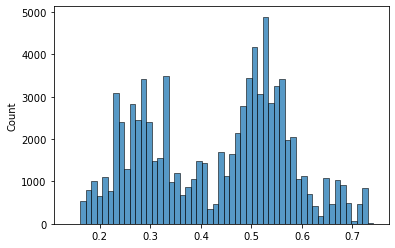

In [958]:
seaborn.histplot(y_pred_nn_raw[:, 1])

# Explainability

# Fairness